In [1]:
!pip install yfinance
!pip install talib-binary
!pip install python-binance

You should consider upgrading via the '/home/matias/.pyenv/versions/3.9.8/envs/binance/bin/python3.9 -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement talib-binary (from versions: none)
ERROR: No matching distribution found for talib-binary
You should consider upgrading via the '/home/matias/.pyenv/versions/3.9.8/envs/binance/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/matias/.pyenv/versions/3.9.8/envs/binance/bin/python3.9 -m pip install --upgrade pip' command.


In [8]:
import sys
from pathlib import Path

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("../input/crypto-prediction")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/crypto-prediction")
else:
    repo_path = Path("/home/matias/crypto-prediction")
sys.path.append(str(repo_path))

import pickle
from dataclasses import dataclass
from datetime import datetime, timedelta

import get_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import talib
import tensorflow as tf
import yfinance as yf
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from tensorflow.keras import layers
from tensorflow.keras.activations import sigmoid, tanh
from tensorflow.keras.models import Model
from tools import inspect_code, plotting, training, wandb_api
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm
from wandb.keras import WandbCallback

import wandb

log_wandb = True
tf.config.list_physical_devices("CPU")[0].device_type


'CPU'

In [3]:
if log_wandb:
    import wandb

    wandb_api.login()
    run = wandb.init(
        project="crypto-prediction",
        group="Initial Gan",
        job_type="test",
    )


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matiasetcheverry (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc
2022-03-26 15:22:47.861793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-26 15:22:47.861835: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
@dataclass
class Datapoint(object):
    ticker: str = "BTC"
    beginning_date: datetime = datetime.now()
    ending_date: datetime = datetime.now()
    interval: str = "1d"
    features: np.ndarray = np.empty(1)
    labels: np.ndarray = np.empty(1)

    def __post_init__(self):
        assert len(self.features) == len(self.labels)
        self.length = len(self.features)
    
    def isempty(self):
        return len(self.features) == 0

class DataModule:
    def __init__(
        self,
        config,
        csv_file=None,
        train_df=None,
        test_df=None,
        train_dataset=None,
        validation_dataset=None,
    ):
        super().__init__()
        self.config = config

        if csv_file is not None:
            self.df = pd.read_csv(csv_file, delimiter=";")
            self.df["BEGINNING_DATE"] = pd.to_datetime(
                self.df["BEGINNING_DATE"], dayfirst=True
            )
            self.df["ENDING_DATE"] = pd.to_datetime(
                self.df["ENDING_DATE"], dayfirst=True
            )

        self.train_df = train_df.convert_dtypes() if train_df is not None else None
        self.test_df = test_df.convert_dtypes() if test_df is not None else None
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset

    def _concatenate_indicators(self, data):
        m = list(range(1, 21)) + list(range(40, 241, 20))
        for mi in [0] + m:
            data[f"ir_{mi}"] = data["Close"].shift(mi) / data["Open"].shift(mi) - 1
        for mi in m:
            data[f"cr_{mi}"] = data["Close"].shift(1) / data["Close"].shift(mi + 1) - 1
        for mi in m:
            data[f"or_{mi}"] = data["Open"] / data["Close"].shift(mi) - 1
        data["Direction"] = data["Close"] > data["Open"]
        return data

    def _get_data(
        self,
        ticker=None,
        beginning_date=None,
        ending_date=None,
        interval="12h",
    ):
        try:
            data = get_data.select_data(
                ticker,
                interval,
                # beginning_date = datetime.today() - timedelta(days=59),
                # ending_date= datetime.today()
                beginning_date=beginning_date,
                ending_date=ending_date,
                compute_metrics=self._concatenate_indicators,
                directory="./intraday_rf",
            )
            return data
        except Exception:
            print(f"Ticker {ticker} could not be downloaded")
            return []

    def setup(self):
        datapoints = []
        idx_label = None
        for _, row in self.df.iterrows():
            data = self._get_data(
                ticker=row["TICKER"],
                # beginning_date=datetime.today() - timedelta(days=365),
                # ending_date=datetime.today(),
                beginning_date=datetime.today() - timedelta(days=1460),
                ending_date=datetime.today() - timedelta(days=400),
                interval=self.config["interval"],
            )
            if len(data) > 0:
                data = data.dropna(axis=0)
                data = data.drop(labels="Datetime", axis=1)

                if idx_label is None:
                    idx_label = list(data.columns).index("Direction")
                else:
                    assert idx_label == list(data.columns).index("Direction")
                dp = Datapoint(
                    ticker=row["TICKER"],
                    beginning_date=row["BEGINNING_DATE"],
                    ending_date=row["ENDING_DATE"],
                    features=data.drop(labels="Direction", axis=1).to_numpy(),
                    labels=data["Direction"].to_numpy(),
                )
                if not dp.isempty():
                    datapoints.append(dp)

        test_size = self.config["train_val_test_split"][-1]
        train_size = (1 - self.config["train_val_test_split"][-1])
        n = [
            int(dp.length * train_size)
            for dp in datapoints
        ]

        self.test_datapoints = []
        
        for index, dp in enumerate(datapoints):
            delta = dp.ending_date - dp.beginning_date
            delta_seconds = timedelta(seconds=test_size*delta.total_seconds())
            dp.beginning_date = dp.ending_date - delta_seconds
            dp.features = dp.features[n[index]:]
            dp.labels = dp.labels[n[index]:]
            dp.length = len(dp.features) - n[index]
            self.test_datapoints.append(dp)

        features = np.concatenate(
            [dp.features[:ni, 6:] for ni, dp in zip(n, datapoints)], axis=0
        )
        labels = np.concatenate([dp.labels[:ni] for ni, dp in zip(n, datapoints)], axis=0)

        p = np.random.permutation(len(features))
        features, labels = features[p], labels[p]
        train_size = int(
            config["train_val_test_split"][0]
            / (1 - self.config["train_val_test_split"][-1])
            * len(features)
        )
        self.train_dataset = (features[:train_size], labels[:train_size])
        self.val_dataset = (features[train_size:], labels[train_size:])


In [10]:
max_precision = 0

n_estimators = [2000]
max_depths = [10, 15]
intervals = ["1d", "12h", "6h"]
forests = []

for interval in intervals:
    for n_row, n_estimator in enumerate(n_estimators):
        for n_col, max_depth in enumerate(max_depths):
            if log_wandb:
                import wandb

                wandb_api.login()
                run = wandb.init(
                    project="crypto-prediction",
                    group="Initial Gan",
                    job_type="test",
                )

            if log_wandb:
                config = wandb.config
            else:
                config = {}

            config["job_type"] = run.job_type if "run" in locals() else "test"
            config["train_val_test_split"] = [0.7, 0.15, 0.15]
            config["interval"] = interval
            config["n_estimator"] = n_estimator
            config["max_depth"] = max_depth

            dm = DataModule(config, repo_path / "DATE.csv")
            dm.setup()
            train_dataset = dm.train_dataset
            val_dataset = dm.val_dataset

            rf = RandomForestClassifier(
                n_estimators=config["n_estimator"], max_depth=config["max_depth"]
            )
            rf.fit(train_dataset[0], train_dataset[1])
            predictions = rf.predict(val_dataset[0])
            predictions_proba = rf.predict_proba(val_dataset[0])
            recall = recall_score(
                val_dataset[1].reshape(-1, 1),
                predictions.reshape(-1, 1),
            )
            precision = precision_score(
                val_dataset[1].reshape(-1, 1),
                predictions.reshape(-1, 1),
            )
            accuracy = accuracy_score(
                val_dataset[1].reshape(-1, 1),
                predictions.reshape(-1, 1),
            )
            print("interval", interval, "n_estimator:", config["n_estimator"], "max_depth:", config["max_depth"])
            print("Precision:", precision)
            print("Recall:", recall)
            print("Accuracy:", accuracy)
            print("----------------------------------------")
            wandb.log({"precision": precision, "recall": recall, "accuracy": accuracy})
            
            dir_path = run.dir
            filename_datamodule = Path(dir_path) / "datamodule_script.txt"
            with open(filename_datamodule, "w") as file:
                file.write(inspect_code.get_class_code(type(dm)))
            
            wandb.sklearn.plot_roc(val_dataset[1], predictions_proba, ["down", "up"])
            wandb.sklearn.plot_precision_recall(val_dataset[1], predictions_proba, ["down", "up"])

            if precision > max_precision:
                print("Saving model")
                # max_precision = precision
                with open("rf.pkl", "wb") as file:
                    pickle.dump(rf, file)
                wandb.save("rf.pkl")
            run.finish()

            del dm
            del rf

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc
2022-03-26 23:12:30.352916: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-26 23:12:30.352972: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

accuracy,▁
precision,▁
recall,▁
accuracy,0.72851
precision,0.74458
recall,0.76866


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc
2022-03-26 23:13:31.987864: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-26 23:13:31.987917: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


interval 1d n_estimator: 2000 max_depth: 15
Precision: 0.819620253164557
Recall: 0.9119718309859155
Accuracy: 0.83984375
----------------------------------------
Saving model



accuracy,▁
precision,▁
recall,▁
accuracy,0.83984
precision,0.81962
recall,0.91197


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc
2022-03-26 23:14:19.201543: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-26 23:14:19.201604: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

accuracy,▁
precision,▁
recall,▁
accuracy,0.71807
precision,0.70533
recall,0.80273


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc
2022-03-26 23:16:59.441200: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-26 23:16:59.441281: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[*********************100%***********************]  1 of 1 completed
Ticker FLOKI could not be downloaded
interval 12h n_estimator: 2000 max_depth: 15
Precision: 0.8435114503816794
Recall: 0.8893360160965795
Accuracy: 0.8432494279176201
----------------------------------------
Saving model



accuracy,▁
precision,▁
recall,▁
accuracy,0.84325
precision,0.84351
recall,0.88934


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc
2022-03-26 23:18:12.103317: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-26 23:18:12.103379: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

accuracy,▁
precision,▁
recall,▁
accuracy,0.67092
precision,0.64855
recall,0.76226


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc
2022-03-26 23:23:22.667168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-26 23:23:22.667229: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[*********************100%***********************]  1 of 1 completed
Ticker FLOKI could not be downloaded
interval 6h n_estimator: 2000 max_depth: 15
Precision: 0.8245614035087719
Recall: 0.9029779058597502
Accuracy: 0.8423258250392875
----------------------------------------
Saving model



accuracy,▁
precision,▁
recall,▁
accuracy,0.84233
precision,0.82456
recall,0.90298


n_estimator: 1 max_depth: 1
Recall: 0.9198542805100182
Precision: 0.4926829268292683
Accuracy: 0.4946236559139785
----------------------------------------
n_estimator: 1 max_depth: 10
Recall: 0.4972677595628415
Precision: 0.5363457760314342
Accuracy: 0.5412186379928315
----------------------------------------
n_estimator: 5 max_depth: 1
Recall: 0.6484517304189436
Precision: 0.5042492917847026
Accuracy: 0.5134408602150538
----------------------------------------
n_estimator: 5 max_depth: 10
Recall: 0.5865209471766849
Precision: 0.5561312607944733
Accuracy: 0.5663082437275986
----------------------------------------
n_estimator: 10 max_depth: 1
Recall: 0.7959927140255009
Precision: 0.5052023121387283
Accuracy: 0.5161290322580645
----------------------------------------
n_estimator: 10 max_depth: 10
Recall: 0.5956284153005464
Precision: 0.5431893687707641
Accuracy: 0.5546594982078853
----------------------------------------
n_estimator: 100 max_depth: 1
Recall: 0.6885245901639344
Precisio

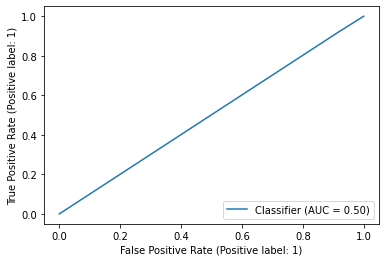

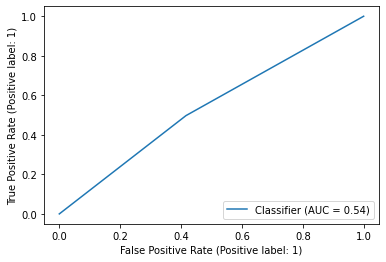

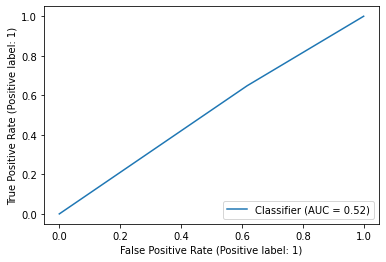

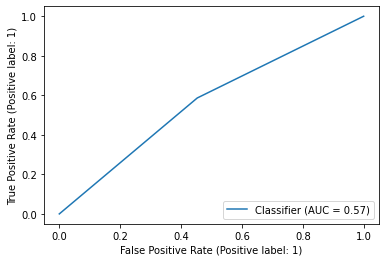

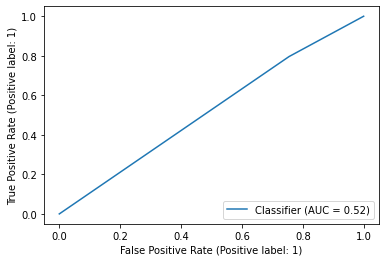

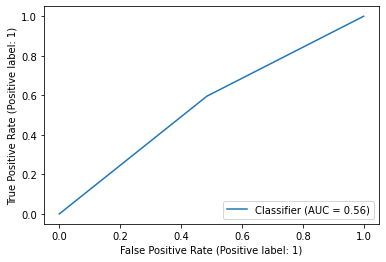

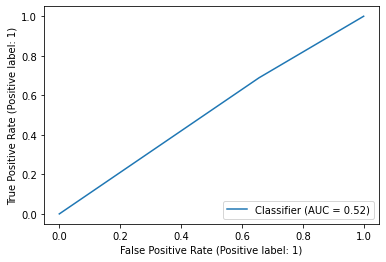

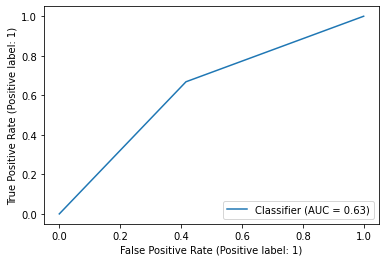

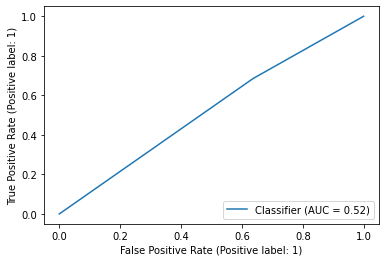

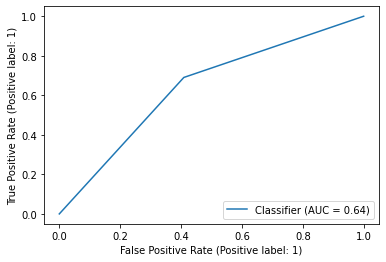

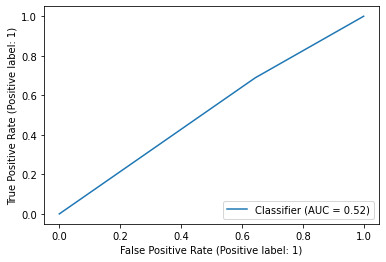

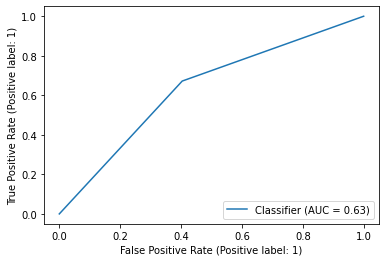

In [ ]:
n = 5

# fig, axs = plt.subplots(
#     len(n_estimators),
#     len(max_depths),
#     figsize=(len(max_depths) * n, len(n_estimators) * n),
# )
for dict in forests:
    rf = dict["forest"]
    predictions = rf.predict(val_dataset[0])
    print(
        "n_estimator:",
        dict["n_estimator"],
        "max_depth:",
        dict["max_depth"],
    )
    print(
        "Recall:",
        recall_score(
            val_dataset[1].reshape(-1, 1),
            predictions.reshape(-1, 1),
        ),
    )
    print(
        "Precision:",
        precision_score(
            val_dataset[1].reshape(-1, 1),
            predictions.reshape(-1, 1),
        ),
    )
    print(
        "Accuracy:",
        accuracy_score(
            val_dataset[1].reshape(-1, 1),
            predictions.reshape(-1, 1),
        ),
    )

    print("----------------------------------------")
    display = metrics.RocCurveDisplay.from_predictions(
        val_dataset[1].reshape(-1, 1),
        predictions.reshape(-1, 1),
    )

    # axs[n_row, n_col].plot(
    #     threshold_proba,
    #     [
    #         accuracy_score(
    #             val_dataset[1].reshape(-1, 1),
    #             predictions[i].reshape(-1, 1),
    #         )
    #         for i in range(len(threshold_proba))
    #     ],
    #     label="Accuracy",
    # )
    # axs[n_row, n_col].plot(
    #     threshold_proba,
    #     [
    #         precision_score(
    #             val_dataset[1].reshape(-1, 1),
    #             predictions[i].reshape(-1, 1),
    #             zero_division=0,
    #         )
    #         for i in range(len(threshold_proba))
    #     ],
    #     label="Precision",
    # )
    # axs[n_row, n_col].plot(
    #     threshold_proba,
    #     [
    #         recall_score(
    #             val_dataset[1].reshape(-1, 1),
    #             predictions[i].reshape(-1, 1),
    #         )
    #         for i in range(len(threshold_proba))
    #     ],
    #     label="Recall",
    # )
    # axs[n_row, n_col].legend()
